# Practical n°3: Pixel-scale Prediction - Weakly Supervised Case

## Part II: denoising with FCN - weakly-supervised approaches




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [2]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 399 (delta 122), reused 141 (delta 93), pack-reused 210
Receiving objects: 100% (399/399), 77.81 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (162/162), done.


In [3]:
! ls

ml-student  sample_data


In [4]:
#On se branche au répertoire contenant utile.py:
os.chdir('ml-student/TP3')

In [5]:
os.listdir('.')
from utile import *

###Exercise 1: The "noise to noise" scenario

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of independently noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The gen_noise2noise function allows us to sample from both datasets:

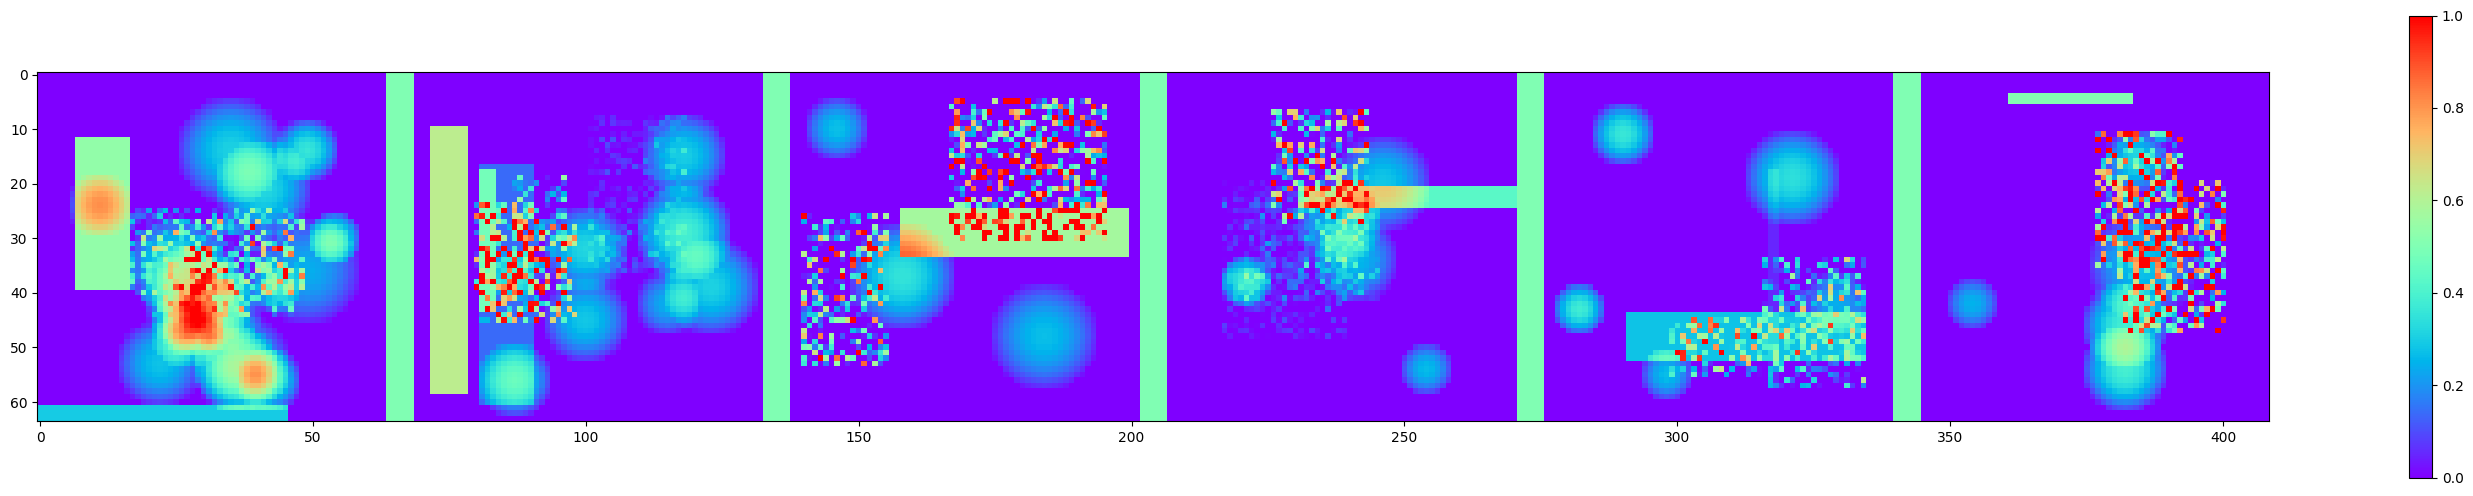

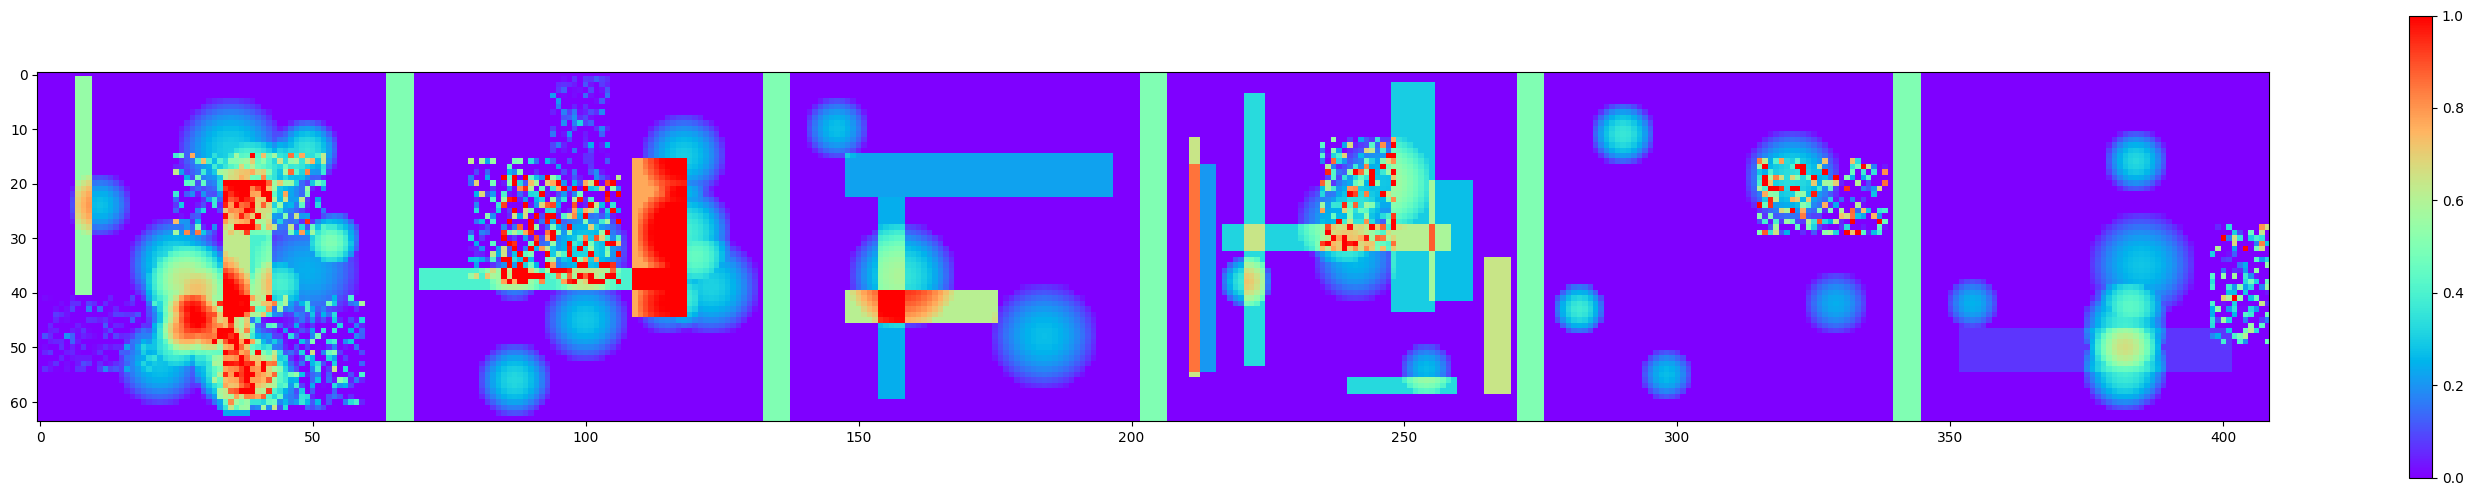

In [6]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Define a learning procedure that effectively denoises the image.

In [7]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [11]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  return torch.mean(torch.abs(output-target))  # idea: use the MAE loss to target the conditionnal median

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_noise2noise(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()  # Zero the gradients
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backward pass



        # Update weights
        optimizer.step()  # Update the weights

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.121537626
Epoch 1
epoch loss : 

0.0888555
Epoch 2
epoch loss : 

0.0854231
Epoch 3
epoch loss : 

0.08423196
Epoch 4
epoch loss : 

0.08336933
Epoch 5
epoch loss : 

0.081596
Epoch 6
epoch loss : 

0.08243527
Epoch 7
epoch loss : 

0.08134903
Epoch 8
epoch loss : 

0.08091895
Epoch 9
epoch loss : 

0.080041505
Epoch 10
epoch loss : 

0.08070241
Epoch 11
epoch loss : 

0.08021182
Epoch 12
epoch loss : 

0.08030785
Epoch 13
epoch loss : 

0.08051853
Epoch 14
epoch loss : 

0.07968617
Epoch 15
epoch loss : 

0.07974465
Epoch 16
epoch loss : 

0.07920475
Epoch 17
epoch loss : 

0.07914201
Epoch 18
epoch loss : 

0.079519555
Epoch 19
epoch loss : 

0.079582274
Epoch 20
epoch loss : 

0.07777189
Epoch 21
epoch loss : 

0.07725962
Epoch 22
epoch loss : 

0.07949079
Epoch 23
epoch loss : 

0.07909135
Epoch 24
epoch loss : 

0.07936589
Epoch 25
epoch loss : 

0.07921174
Epoch 26
epoch loss : 

0.07844941
Epoch 27
epoch loss : 

0.07788758
Epoch 28
epoch loss : 

0.0777

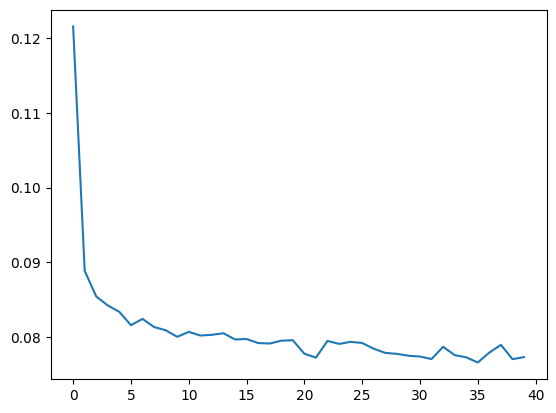

In [12]:
plt.plot(train_losses)

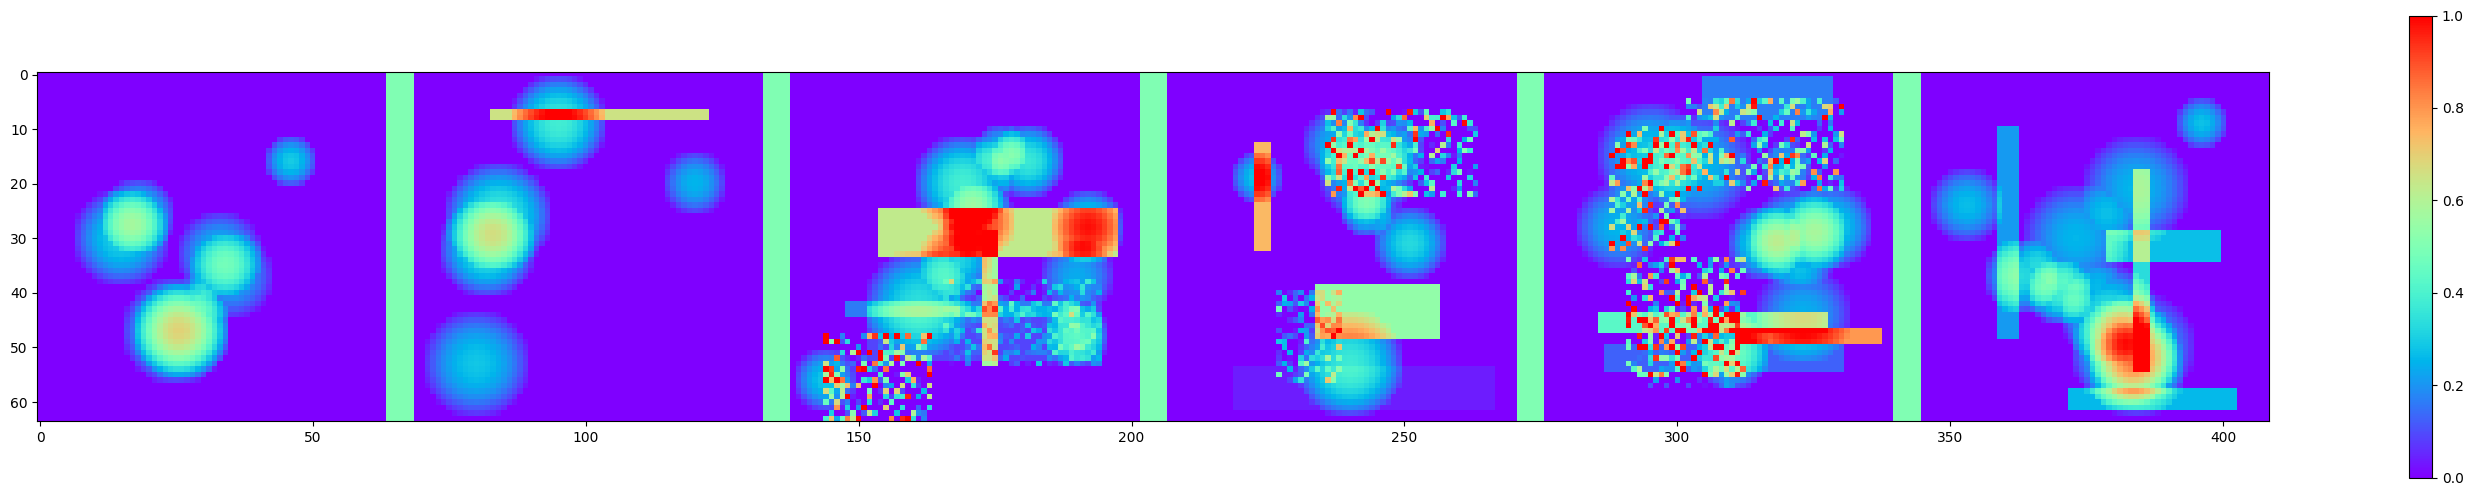

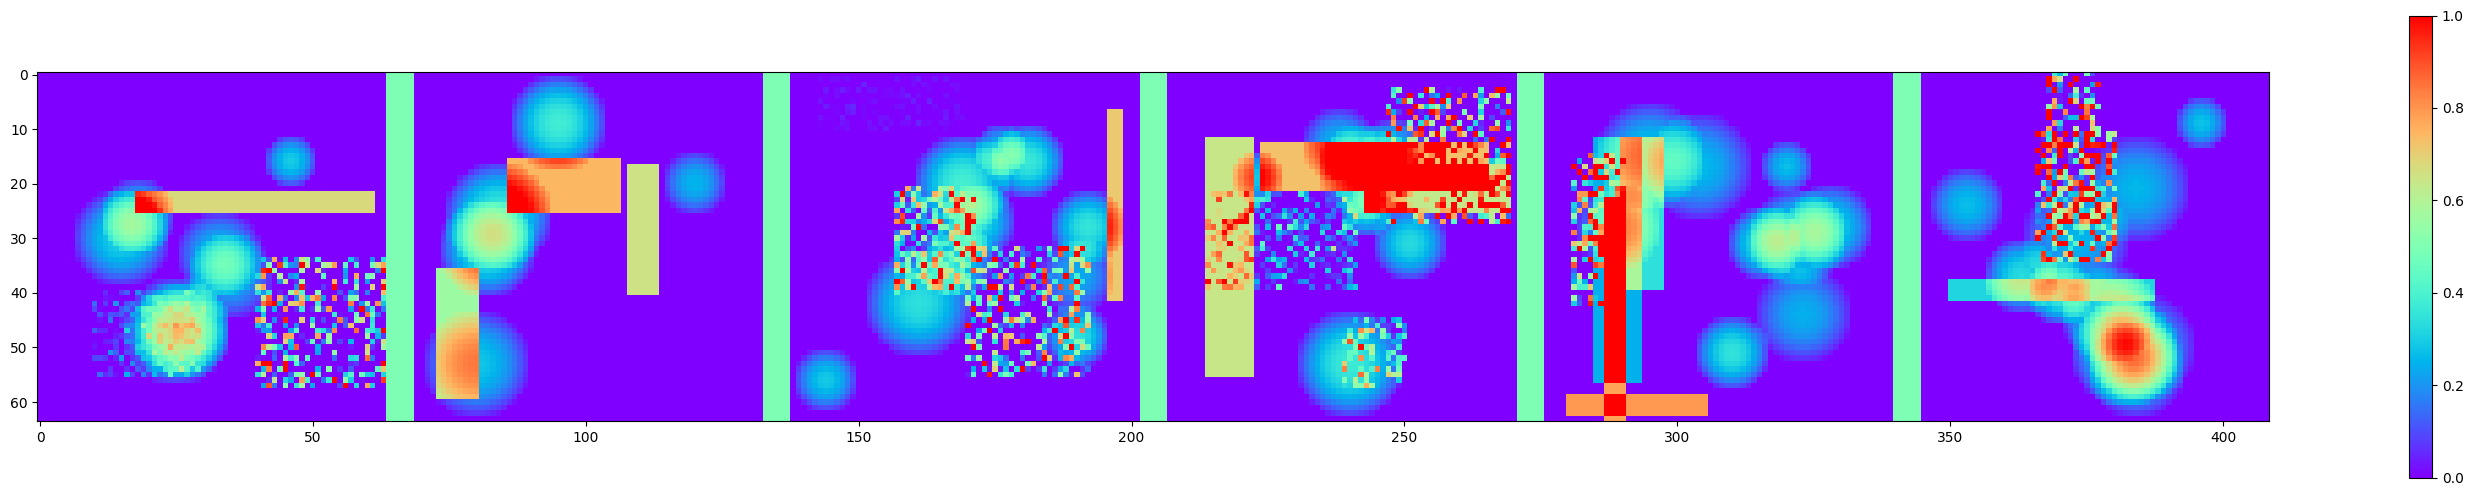

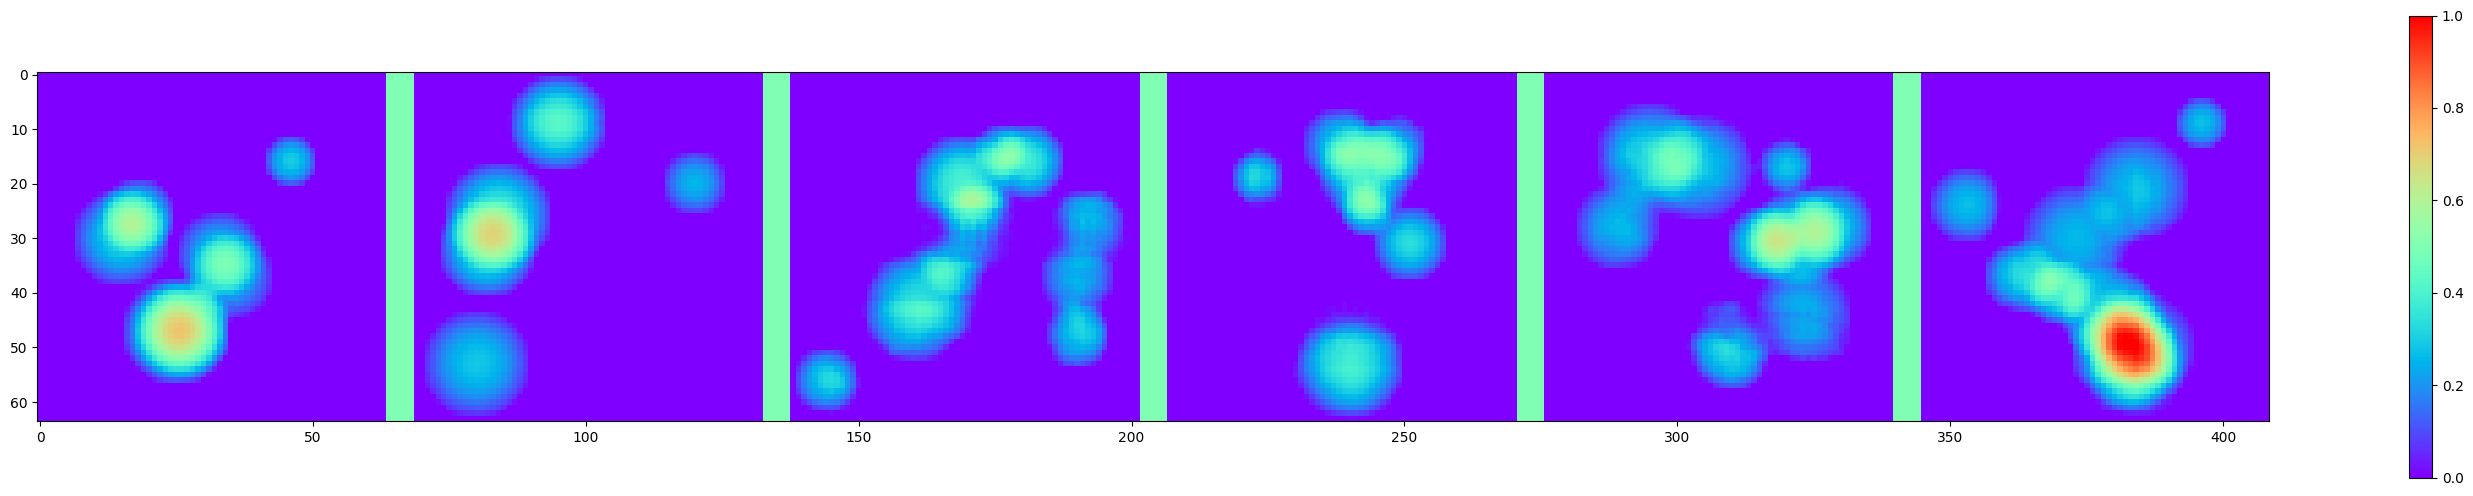

In [14]:
# viz:

fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())


fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs

**Q2** Theoretical analysis.

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite equation (1) to justify the approach taken for **Q1**.

We rewrite the expectation to be minimized in the case of a cost function equal to the Mean Absolute Error (MAE):

\begin{equation}
 \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] = \mathbb{E}_{X}[ \mathbb{E}_{Y | X}\ |f_\theta(X) - Y | \ ]
\end{equation}

To reach the minimum, the network must provide the conditional median of Y given X . In the case of a quadratic cost function, the network will suggest the conditional expectation. Unlike the median, this is biased, as noise always contribute positively.


###Exercise 2: The "NES" scenario (Neural Egg Separation)

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).



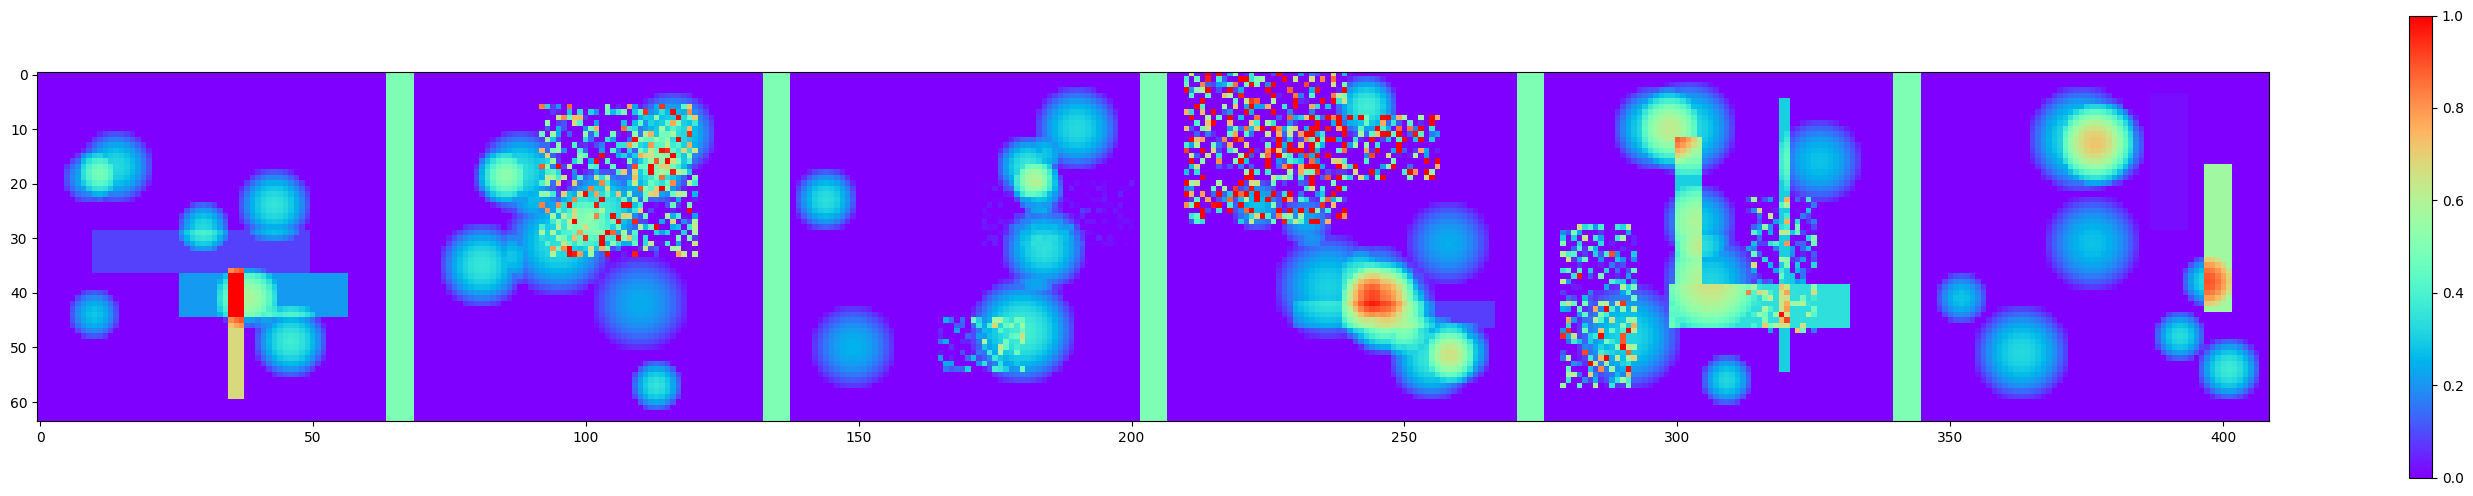

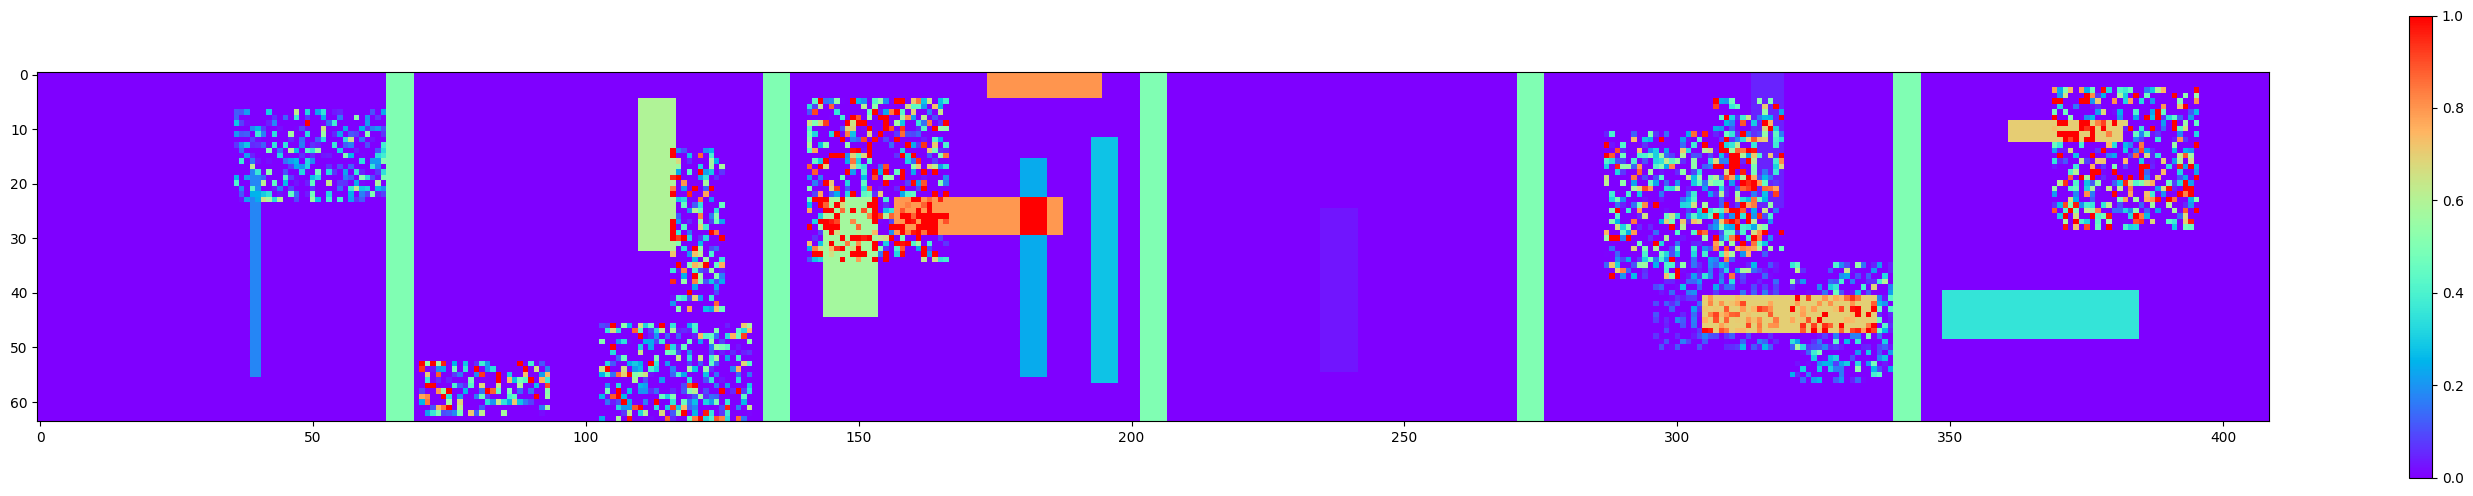

In [15]:
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample the noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Propose a learning strategy that leads to effective denoising.

**Q2** Discuss the limitations of the method and mention some avenues for improvement.

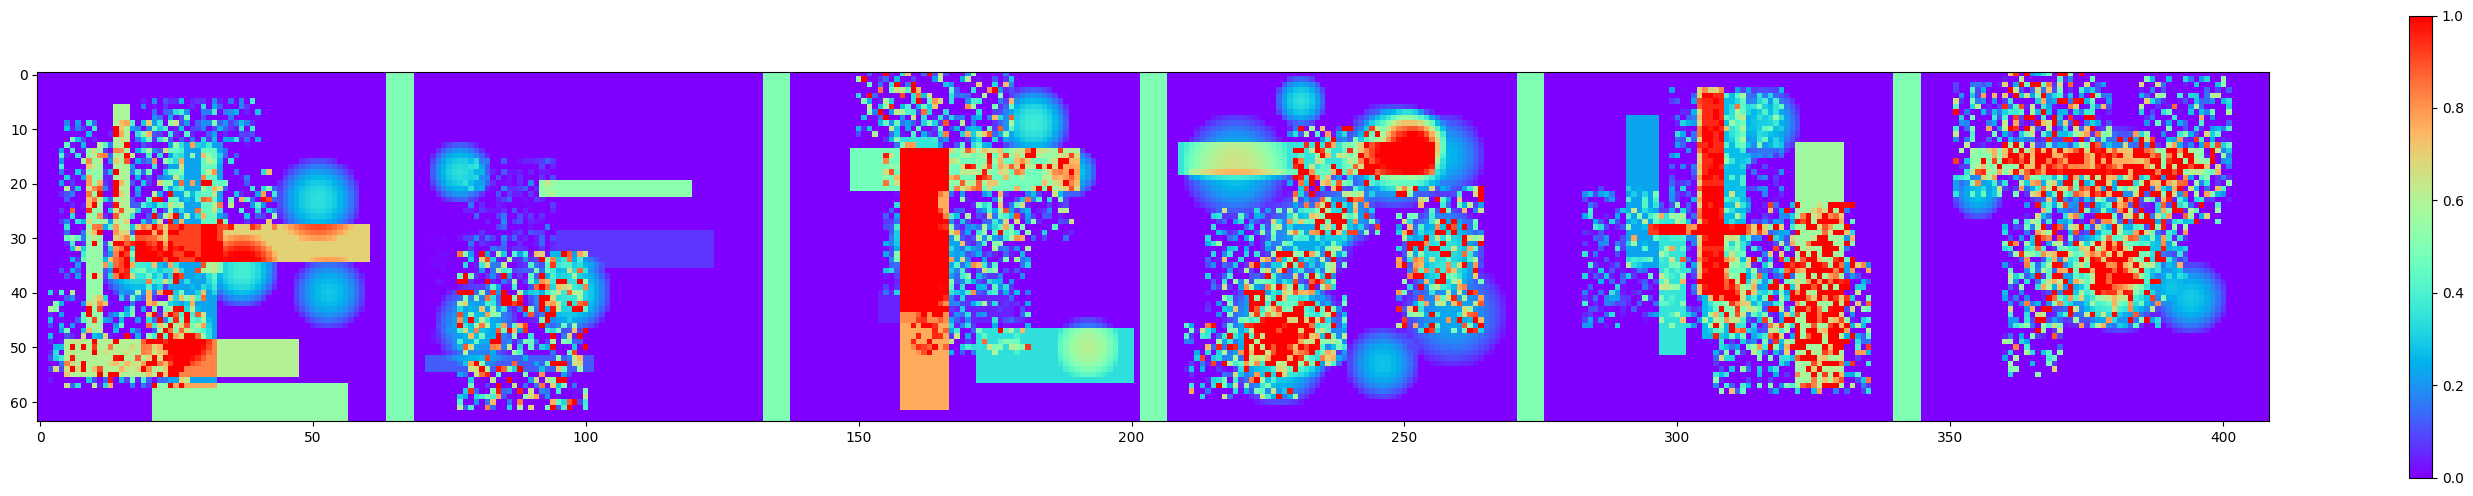

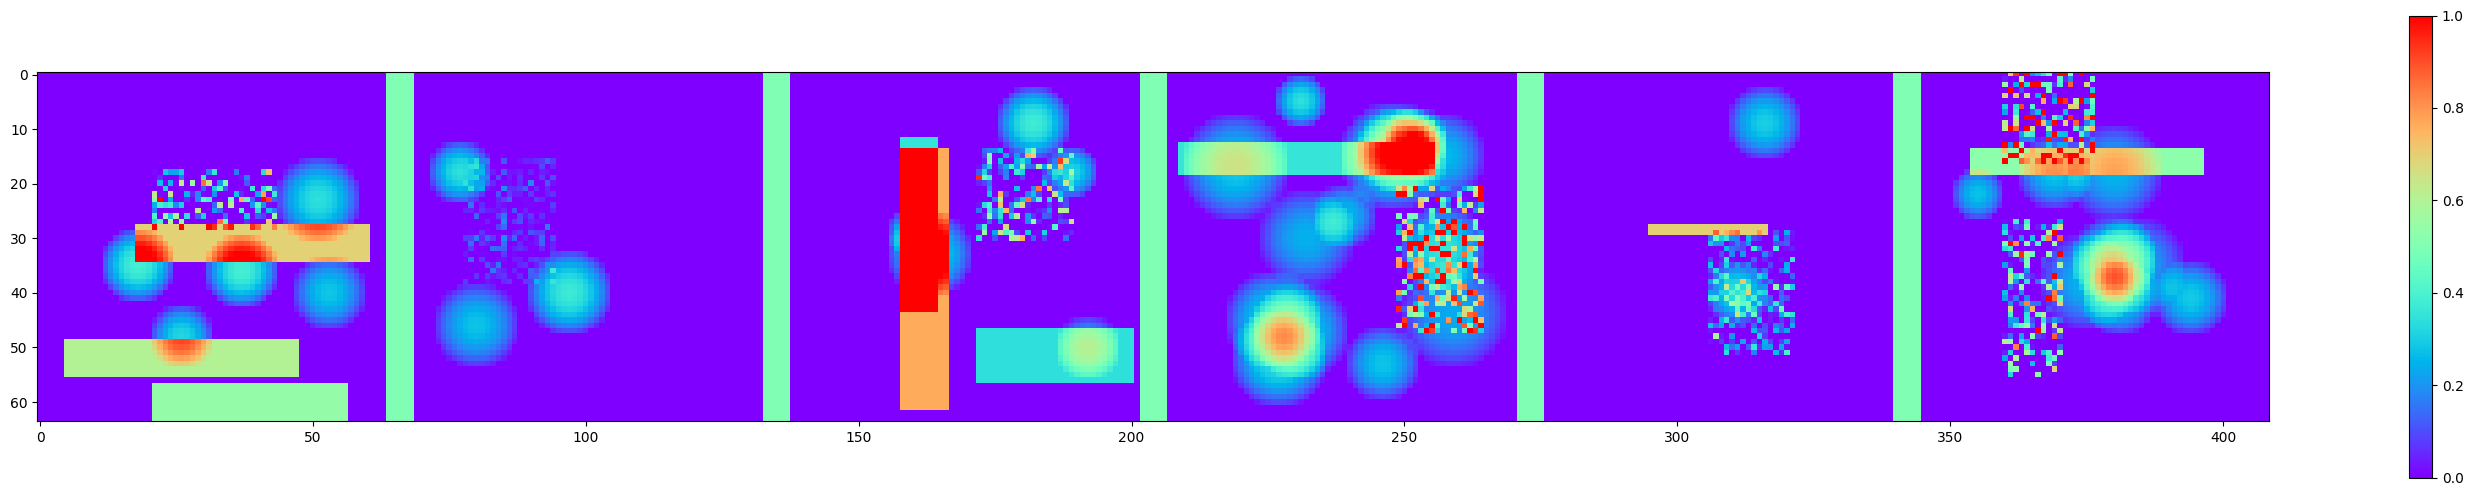

In [16]:

# Examples of (input, target) couples:

batchsize = 6
# Get image + noise and additional noises
image = gen1_NES(batchsize)
noise = gen2_NES(batchsize)
noise2 = gen2_NES(batchsize)

# Build input and targets
input = image + noise + noise2
target = image

# inputs
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

# targets
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)